----
# Logistic Regression with Augmented Data
----
### Summary:

To evaluate the performance of the baseline Logistic Regression model when trained on augmented data. By augmenting MNIST sign language dataset, more noise is added to the images which simulate real-world scenario. Training the model on augmented data allows the model to generalise better and therefore become more robust.

### Notebook Overview:

- **Data Augmentation**:
    - Load augmented data and put into an array format for model compatibility.

- **Build Logistic Regression Model**:
    - Train a Logistic Regression model on the augmented data.
    - Compare the performance of the model with and without augmentation.

- **Model Evaluation**:
    - Evaluate the accuracy and performance of the Logistic Regression model.
    - Assess model coefficients to see what model has learnt when data includes augmentation

### Data Augmentation Reminder:

- rescale=1./255             > Normalisation of the input data is best when working with neural networks
- rotation_range=20          > To enusre model is able to deal with slight tilts in the hand position, most likley to occur in the real world
- width_shift_range=0.1      > To ensure model is able to deal with off-centered images
- height_shift_range=0.1     > To ensure model is able to deal with off-centered images
- shear_range=0.2            > To distort the image, similar to when we see objects from different perspectives
- zoom_range=0.2             > Zooms in and out of images so model is able to recognise signs when hands are of different sizes/furhter/closer.
- horizontal_flip=False      > Not applying horizontal flip as this would add confusion since sign language signs require specific orientations.


## Set Up

In [2]:
# List of imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

import joblib

## Data Loading

In [2]:
# connect to google drive -> required for input image later
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
X_aug = joblib.load( '../../model/my_files/X_train_aug.pkl')
y_aug = joblib.load( '../../model/my_files/y_train_aug.pkl')

In [4]:
X_valid = joblib.load( '../../model/my_files/X.pkl')
y_valid = joblib.load( '../../model/my_files/y.pkl')

In [5]:
all_images = []

# Iterate over each array in X_aug
for batch in X_aug:
    # Iterate over each image in the batch
    for image in batch:
        # Append the image to the list of all images
        all_images.append(image)

# Convert the list of images to a NumPy array
all_images_array = np.array(all_images)

In [6]:
all_class = []

# Iterate over each array in X_aug
for batch in y_aug:
    # Iterate over each image in the batch
    for c in batch:
        # Append the image to the list of all images
        all_class.append(c)

# Convert the list of images to a NumPy array
all_class_array = np.array(all_class)

In [7]:
all_images_array.shape

(83103, 28, 28, 1)

In [8]:
# Convert the list of images to a NumPy array
all_class_array.shape

(83103,)

In [9]:
X = all_images_array.reshape(-1,28,28)
y = all_class_array

In [10]:
X.shape # Sanity Check

(83103, 28, 28)

In [11]:
y.shape

(83103,)

In [17]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
# To store unique class values - to be used later in loops
unique_values, value_counts = np.unique(y, return_counts=True)

NameError: name 'y' is not defined

## Utility Functions

In [13]:
# Creating a function to compare exponentials of coefficients with the mean image for a given letter
def assess_coef(coef, letter='a'):
    '''
    Overview:
    Plots the mean image of a given letter and the odds ratio image based on model coefficients.

    Arguments:
        - coef -> Model coefficients for all letters/classes
        - letter -> Letter (NOT J/Z as both of these letters do not exist in dataset)

    Output:
        - 2 figures:
            -  mean image of given letter
            - 'odds ratio' pixel image for each given letter

    '''
    # Data set contains no data for letters j and z, to raise error message if input letter is j/z
    if letter.lower() in ('j', 'z'):
        raise ValueError("The input letter cannot be 'j' or 'z'.")
    else:

        my_image = X.reshape(-1,28,28)
        my_class = y

        fig, axes = plt.subplots(1,2, figsize=(20, 10))

        # get index of letter as class is int data type
        idx1 = alphabet.index(letter.lower())

        plt.subplot(1,2,1)
        plt.imshow(np.mean(my_image[my_class==idx1], axis = 0) ,cmap='gray')
        plt.title(f'Mean of {letter.upper()}',fontsize='50')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(1,2,2)
        # Using cmap show the odds ratio -> cases where odds ratio is > 1 means certain pixel increases the odss of the image being classified as the target letter
        #                                -> cases where odds ratio is < 1 means certain pixel decreses the odds of the image being classified as the target letter
        plt.imshow(np.exp(coef[idx1]).reshape(28,28),cmap='BuPu')
        # added positioning to make colour bar same height as image
        plt.colorbar(label='Odds Ratio',fraction=0.046, pad=0.04)
        plt.title(f'Odds Ratio for {letter.upper()}',fontsize='50')

        plt.xticks([])
        plt.yticks([])

        plt.tight_layout()
        plt.show()

## Assessing the Augmented Images

##### Printing a single image for each character:

In [14]:
my_image = X
my_class = y

In [15]:
fig, axes = plt.subplots(6,4, figsize=(80, 120))

for target, ax in zip(unique_values, axes.ravel()):
    ax.imshow(my_image[my_class==target][0], cmap = 'gray')
    ax.set_title(alphabet[target].upper(),fontsize=50)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()


##### Printing mean image for each character:

This allows us to assess what features(pixels) the model are most likely to "see" as the most defining for each class. We will revisit this later when we assess the performance of the Logistic Model.

In [16]:
fig, axes = plt.subplots(6, 4, figsize=(80, 120))
for target, ax in zip(unique_values, axes.ravel()):

    ax.imshow(np.mean(my_image[my_class==target], axis = 0), cmap = 'gray')
    ax.set_title(alphabet[target].upper(),fontsize=50)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

**Plot Description:**

By plotting the mean of all images per class with augmentation, it becomes clear jsut how drastic the augmentation has been on the dataset. In contrast to the non-augmented data (refer to notebook 01-log-reg-basic), the distinctive features previouslty observed are now a lot less prominent. Most signs now show more commonality especially in the image center pixels. This will make it challenging for the model to distinguish between different sign language signs. This is reflected in the logistic model's results below, where performance has significantly declined. The basic logistic regression model struggles when images are off-centered and contain more noise, highlighting its limitations despite showing high accuracy in the initial modelling.

## Building the Logistic Regression Model

In [17]:
flattened_dataset = X.reshape(X.shape[0],28 * 28)

In [18]:
X = flattened_dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1)

In [ ]:
# Modify the X values to be 0-1 instead of 0-255
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_val /= 255
# Sanity Check
print(f'X_train range: {X_train.min()}-{X_train.max()}')

In [19]:
my_model = LogisticRegression(solver='saga', penalty='l1', C=1, max_iter=1000)
my_model.fit(X_train, y_train)

In [ ]:
# getting predicted y = to be used for confusion matrix further on in notebook
pred_y = my_model.predict(X_val)

In [ ]:
print(f'train score: {my_model.score(X_train, y_train)}')
print(f'test_score:{my_model.score(X_val,y_val)}')

train score: 0.3894404332129964
test_score:0.32286590868074355


In [29]:
joblib.dump(my_model, '../../model/my_files/my_log_reg_basic_AUG.pkl')

['../../model/my_files/my_log_reg_basic_AUG.pkl']

In [13]:
my_final_model = joblib.load('../../model/my_files/my_log_reg_basic_AUG.pkl')

In [31]:
print(f'train score: {my_final_model.score(X_train, y_train).round(4)}')
print(f'test_score:{my_final_model.score(X_val,y_val).round(4)}')

train score: 0.3894
test_score:0.3229


**Comment:**

Performance is a lot worse as expected as images are no longer centered and uniform.
One thing to note, when loading in the augmented training data, I should have only used the augmented data to train my model. I realise I have used it to perform a validation test which is not correct as I should be assessing the model on non-augmented data. Therefore I am going to take a subset of the original data and run it as a test for my model.

## Model Evaluation


##### Confusion Matrix:
Plotting a confusion matrix shows us the number of correctly and incorrecly classified images of the model.Since performance of the final model (my_model2) is very high we see a low number of misclassifications.

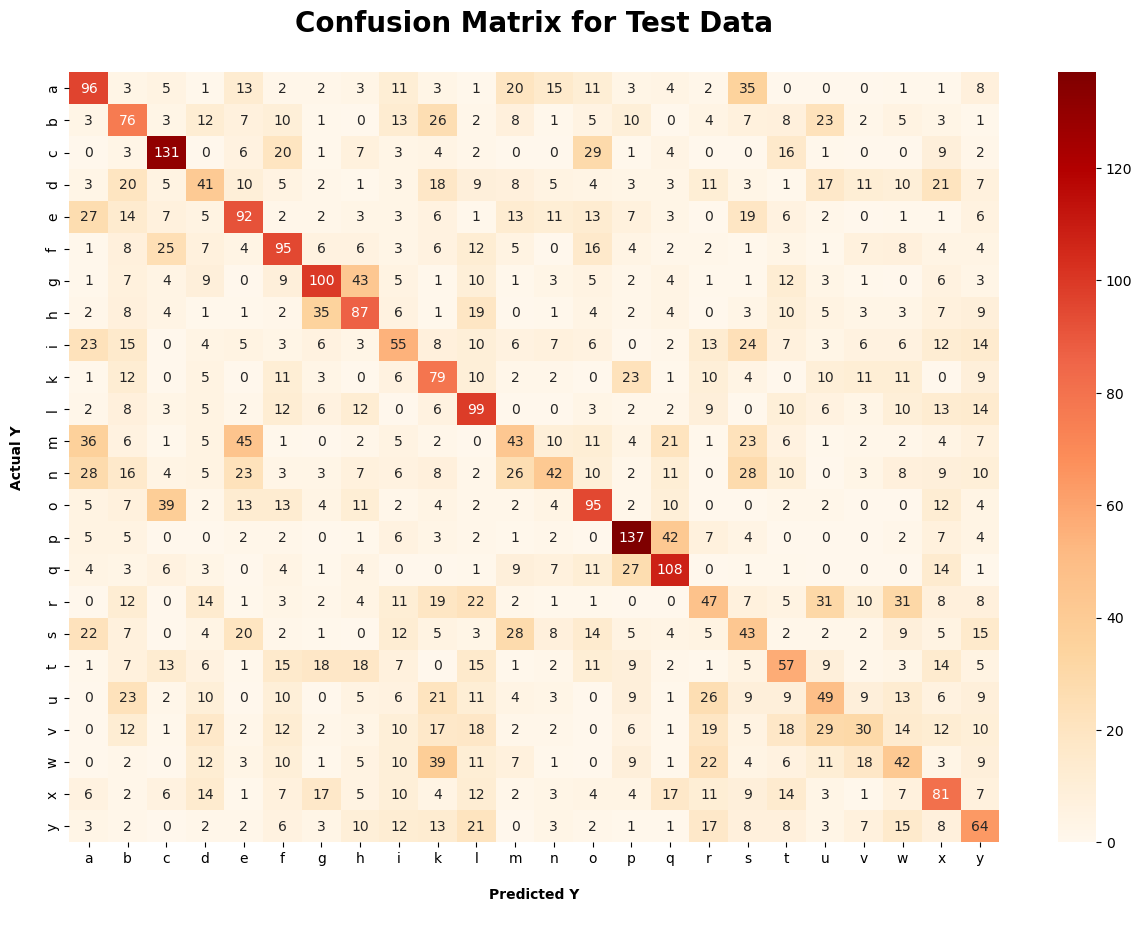

In [38]:
# Calculating the confusion matrix using sklearn.metrics
conf_matrix = confusion_matrix(y_val, pred_y)

plt.figure(figsize=(15, 10))
# Using a heatmap to plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt = 'd', cmap='OrRd') # -> fmt = d casting values to int
plt.title('Confusion Matrix for Test Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
# offsetting postion of ticks by 0.5 to move labels into the centre
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

##### Assessment of Accuracy:

The final model shows us a very high accuracy for both training and test data, it would be interesting to see what pixels (features) are the most defining for each letter when it comes to classification. To do this, I will assess the coefficients of the logistic models for each letter.

In [39]:
# Coefficient for each pixel
letter_coef = my_final_model.coef_

fig, axes = plt.subplots(6,4, figsize=(80, 120))

for i,coef in enumerate(letter_coef):
    plt.subplot(6,4,i+1)
    # To take the exponential each coefficient to output odds ratio
    plt.imshow(np.exp(coef).reshape(28,28) ,cmap='BuPu')
    plt.title(alphabet[i].upper(),fontsize='50') #-> using alphabet_jz as the i is 0 to 24
    plt.xticks([])
    plt.yticks([])
plt.show()

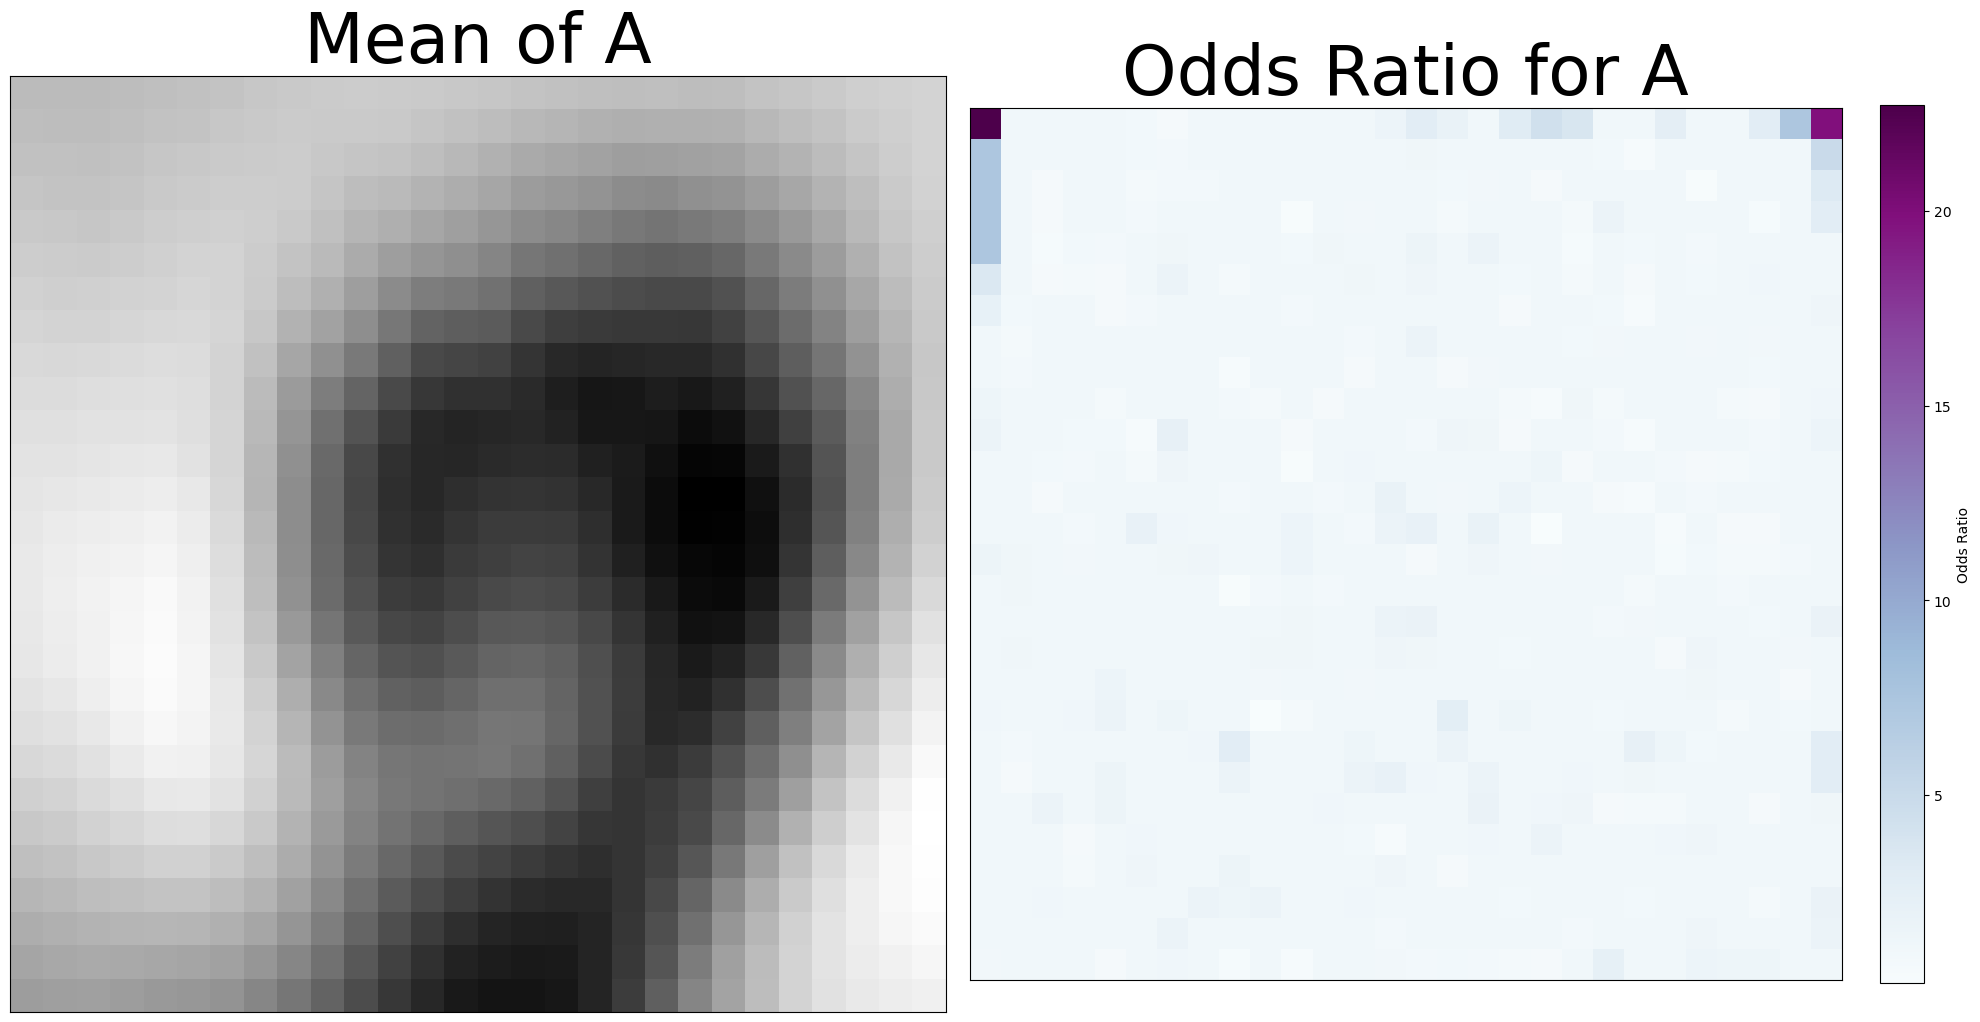

In [40]:
# Getting coefficients again to pass into my new function
letter_coef = my_final_model.coef_
assess_coef(letter_coef,letter='A')

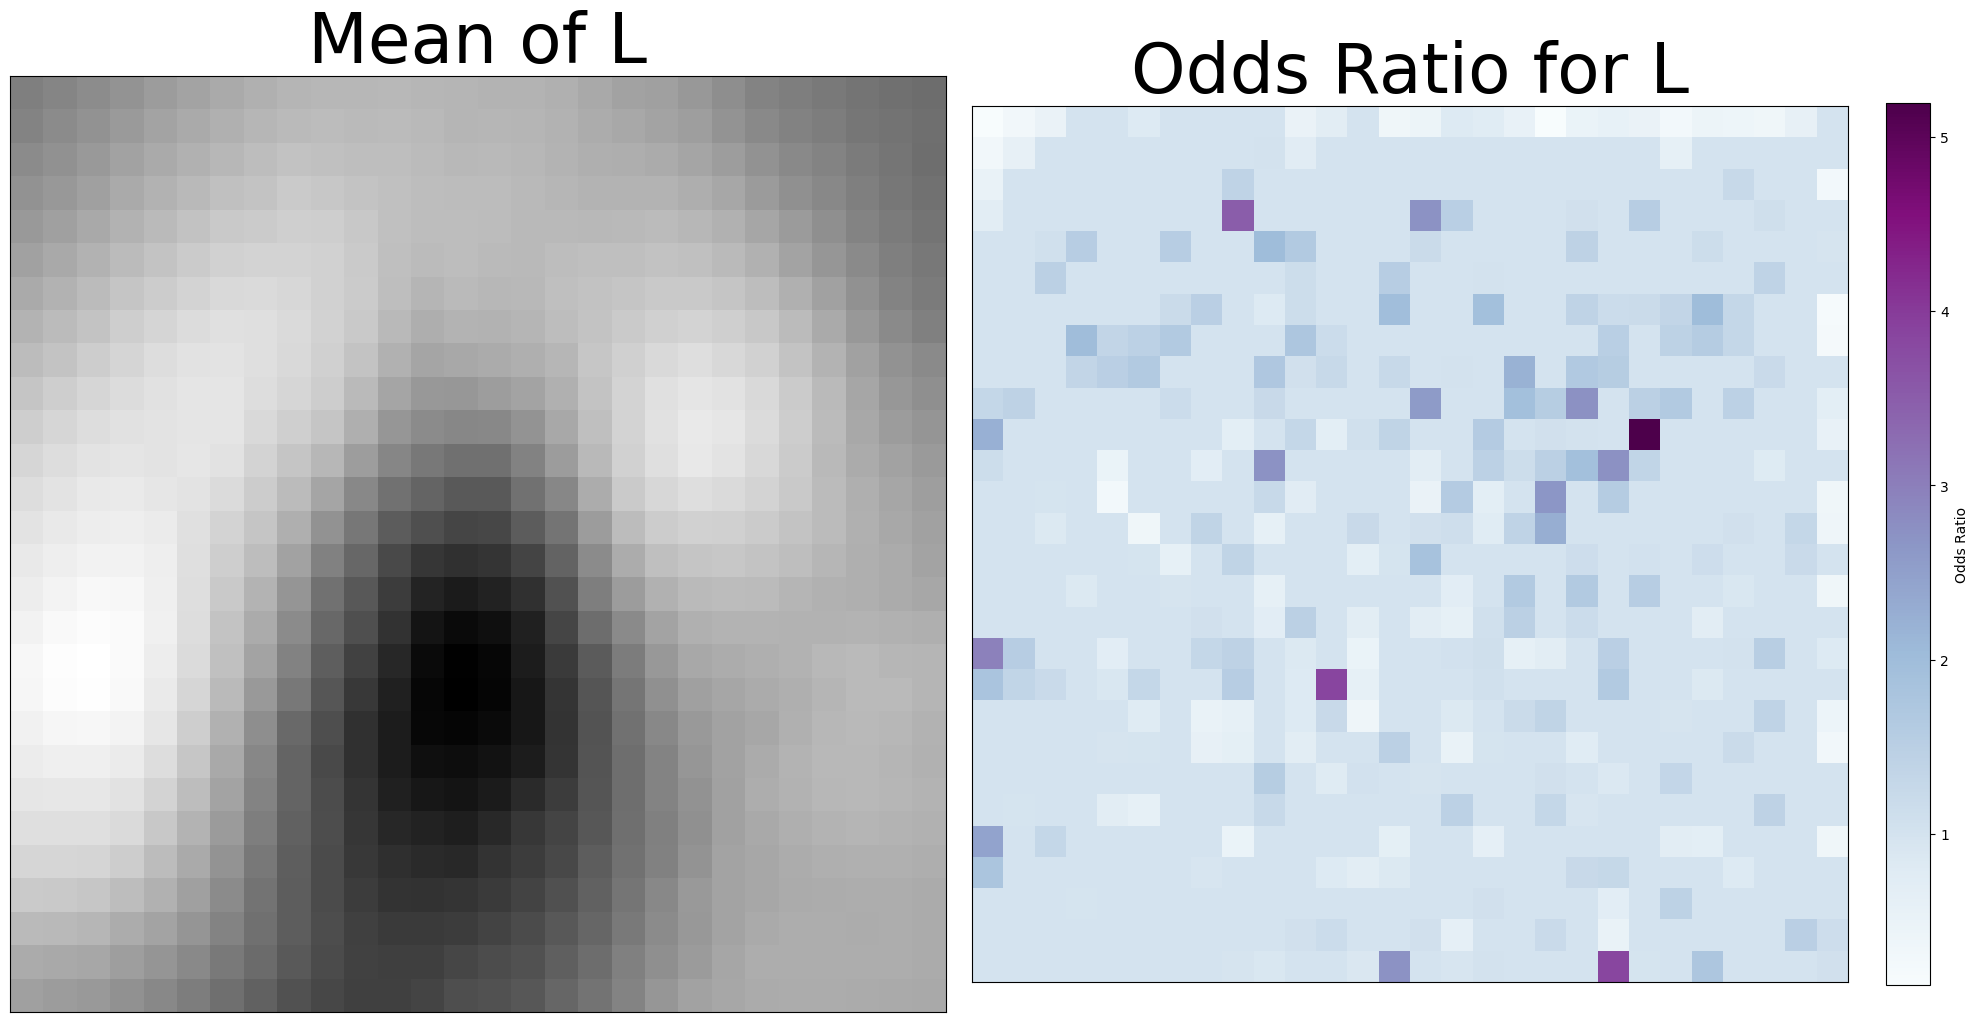

In [41]:
letter_coef = my_final_model.coef_
assess_coef(letter_coef,letter='l')

## Test Image

### Using Keras to load image

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# loading a test image for ASL sign 'C'
image_path = '../../model/my_files/C.JPG'
input_image = load_img(image_path, target_size=(28, 28))
# Convert image to greyscale
input_image = input_image.convert('L')
# Rotating image to have correct orientation (see below)
input_image = input_image.rotate(270)

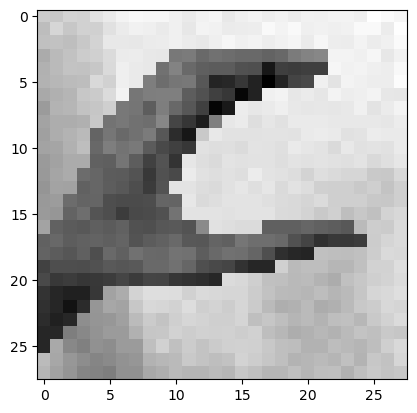

In [8]:
plt.imshow(input_image,cmap='gray') # checking image has correct orientation
plt.show()

In [9]:
# Convert the image to a NumPy array
image_array = img_to_array(input_image)

In [10]:
# Reshaping to have dimesntions (1,28,28,1) -> to match X_train/X_test dimensions
# 1 as only single image is uploaded
test_img = image_array.reshape(1,28*28)

In [14]:
my_final_model = joblib.load('../../model/my_files/my_log_reg_basic_AUG.pkl')

In [15]:
my_final_model.predict(test_img)

array([12])

In [18]:
alphabet[my_final_model.predict(test_img)[0]]

'n'